# Data Cleaning

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing King County Housing Data
df = pd.read_csv('data-pozo/kc_house_data.csv')

Below, we noticed that two home in particularly were incorrectly listed, so we decided to remove those prices from the data set

In [3]:
#drop erroneous data #1
df = df[df["price"] != 40000]

#drop erroneous data #2
df = df[df["price"] != 30108.0]


Below, we are doing some additional data cleaning consisting of remove nulls, dropping duplicate sales, and removing incorrect zipcodes

In [4]:
#drop rows with null values
df.dropna(subset = ['heat_source', 'sewer_system'], inplace = True)

In [5]:
#change date to datetime and split out sale year and month
df['date'] = pd.to_datetime(df['date'])
df['sale_month'] = df['date'].dt.month.astype(int)
df['sale_year'] = df['date'].dt.year.astype(int)

In [6]:
#drop rows containing addresses not in King County
        
zip_list = [98052,98115,98103,98092,98042,98023,98105,98003,98034,98118,98133,98058,98125,98031,98122,98033,98006,98032,98030,98004,98001,98059,98117,98056,98198,98168,98155,98027,98109,98002,98038,98144,98146,98074,98119,98007,98040,98029,98107,98011,98108,98072,98106,98178,98116,98112,98008,98053,98028,98126,98188,98102,98055,98075,98177,98022,98166,98199,98005,98121,98136,98045,98057,98019,98104,98077,98101,98065,98148,98070,98014,98354,98024,98051,98010,98047,98251,98134,98039,98195,98158,98068,98256,98288,98050,98132,98171,98184,98054,98009,98013,98015,98025,98035,98041,98062,98064,98063,98071,98073,98083,98089,98093,98111,98113,98114,98124,98127,98131,98129,98139,98138,98141,98145,98151,98154,98160,98164,98161,98165,98170,98174,98175,98181,98185,98190,98194,98191,98224,98471,98481]
zip_list = list(map(lambda x: str(x), zip_list))

df['in_target_area'] = df['address'].apply(lambda x: any(zip_code in x for zip_code in zip_list))
df = df.drop(df[df['in_target_area'] == False].index)

In [7]:
# Breakout city and zipcode from the address column

def residential_check(value):
    if len(value.split(',')) == 4:
        return True
    if len(value.split(',')) != 4:
        return False

df['residential'] = df['address'].apply(lambda x: residential_check(x))    
df = df.drop(df[df['residential'] == False].index)
df[['House_Num', 'City', 'State_ZIP', 'Country']] = df['address'].str.split(',', expand=True)    
df[['Empty', 'State', 'ZIP']] = df['State_ZIP'].str.split(' ', expand=True) 
df.drop(columns = ['Empty', 'in_target_area', 'residential'], inplace = True)
df["City"] = df["City"].apply(lambda x: x.strip())
df["ZIP"] = df["ZIP"].apply(lambda x: x.strip())
df["House_Num"] = df["House_Num"].apply(lambda x: x.strip())

In [8]:
# Drop all duplicated housing IDs and addresses. Drop homes missing bed/bath data
df['id'].duplicated().value_counts()
df.drop_duplicates(subset = 'id', keep = 'first', inplace = True)


df['address'].duplicated().value_counts() 
df.sort_values(by = ['date'], ascending = False, inplace = True)
df.drop_duplicates(subset = ['address'], keep = 'first', inplace = True)

df = df[(df['bedrooms'] != 0) & (df['bathrooms'] != 0)]
df = df[df['bedrooms'] < 10]

df.reset_index(drop = True, inplace = True)
df.drop(columns=['id', 'date', 'address', 'lat', 'long', 'House_Num', 'State_ZIP', 'Country', 'State'], inplace = True)

Looking at our dataframe below, we can see that we do not have any null values

In [9]:
#initial clean dataset, dropping useless columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28964 entries, 0 to 28963
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          28964 non-null  float64
 1   bedrooms       28964 non-null  int64  
 2   bathrooms      28964 non-null  float64
 3   sqft_living    28964 non-null  int64  
 4   sqft_lot       28964 non-null  int64  
 5   floors         28964 non-null  float64
 6   waterfront     28964 non-null  object 
 7   greenbelt      28964 non-null  object 
 8   nuisance       28964 non-null  object 
 9   view           28964 non-null  object 
 10  condition      28964 non-null  object 
 11  grade          28964 non-null  object 
 12  heat_source    28964 non-null  object 
 13  sewer_system   28964 non-null  object 
 14  sqft_above     28964 non-null  int64  
 15  sqft_basement  28964 non-null  int64  
 16  sqft_garage    28964 non-null  int64  
 17  sqft_patio     28964 non-null  int64  
 18  yr_bui

# EDA: Exploring Price Correlation, Multi-colinearity and Normality

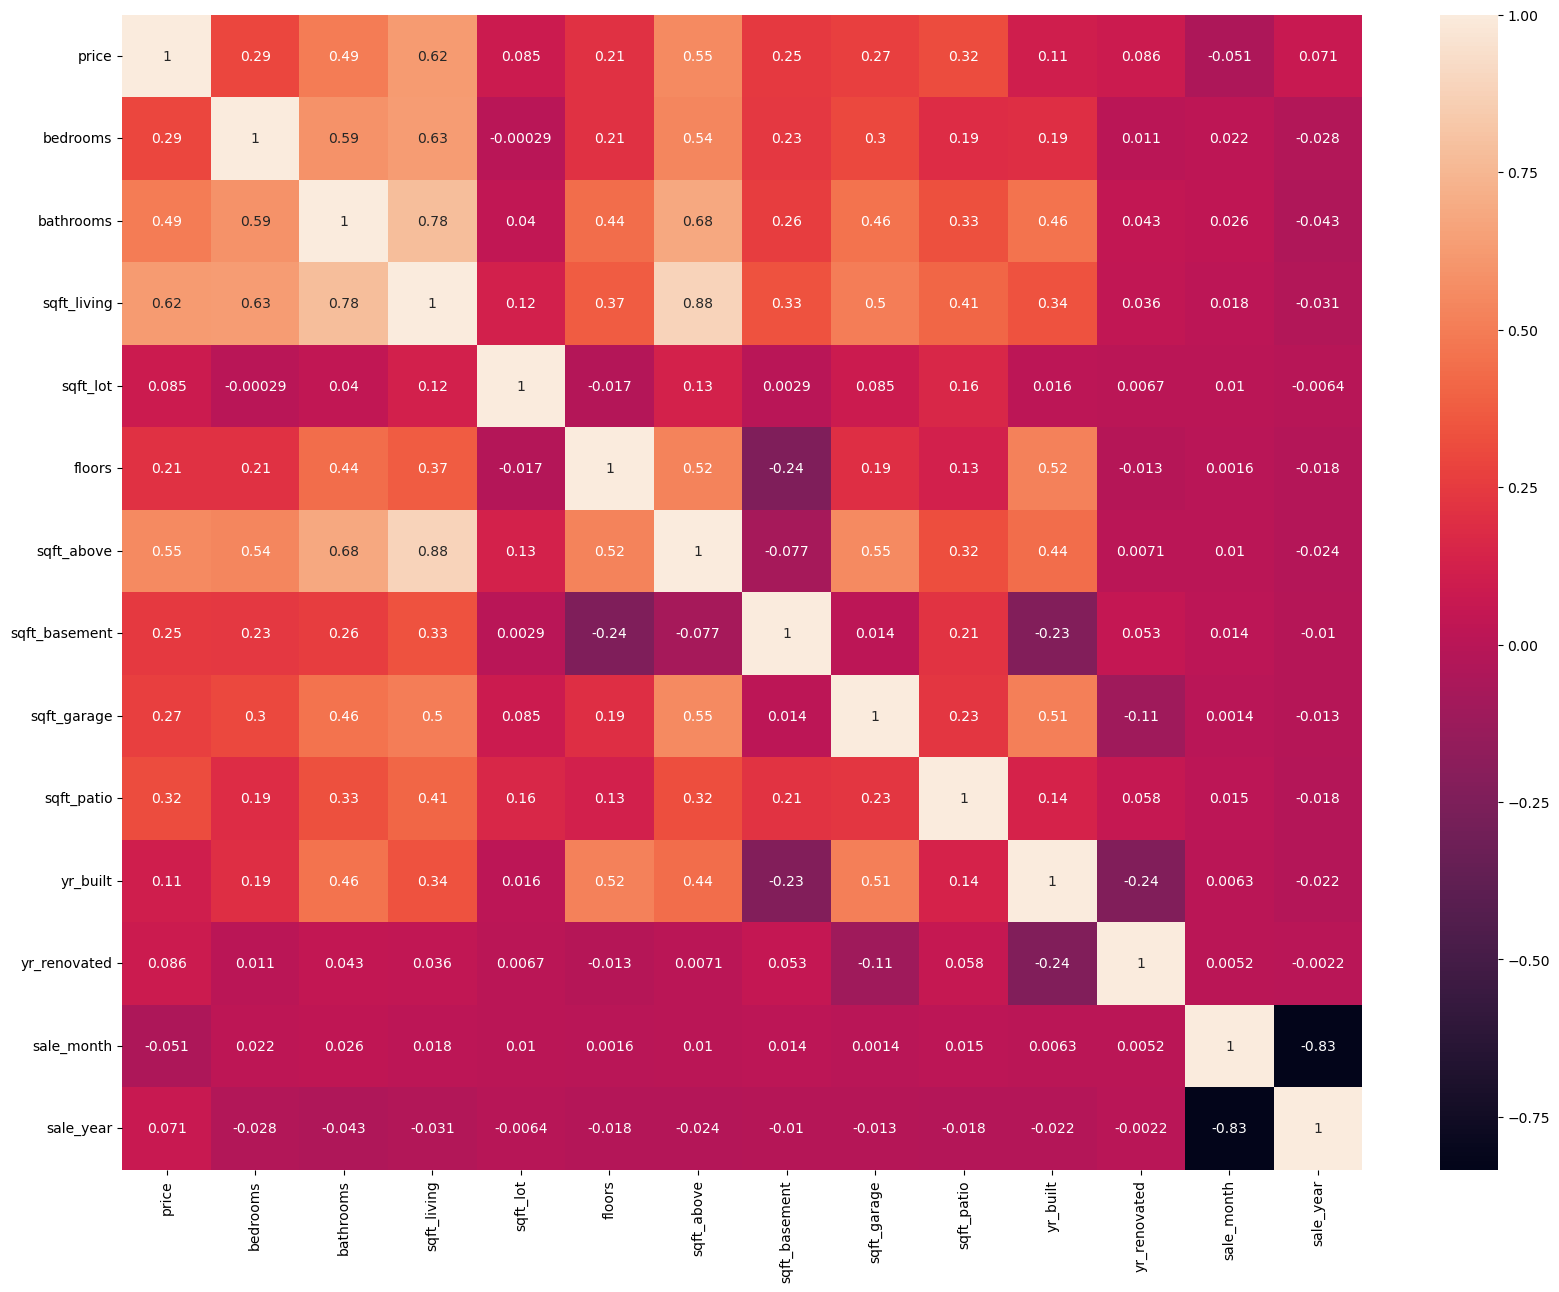

In [10]:
#Run heatmap to identify highly correlated variables to identify possible multi-colinearity 
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot = True)
plt.show();

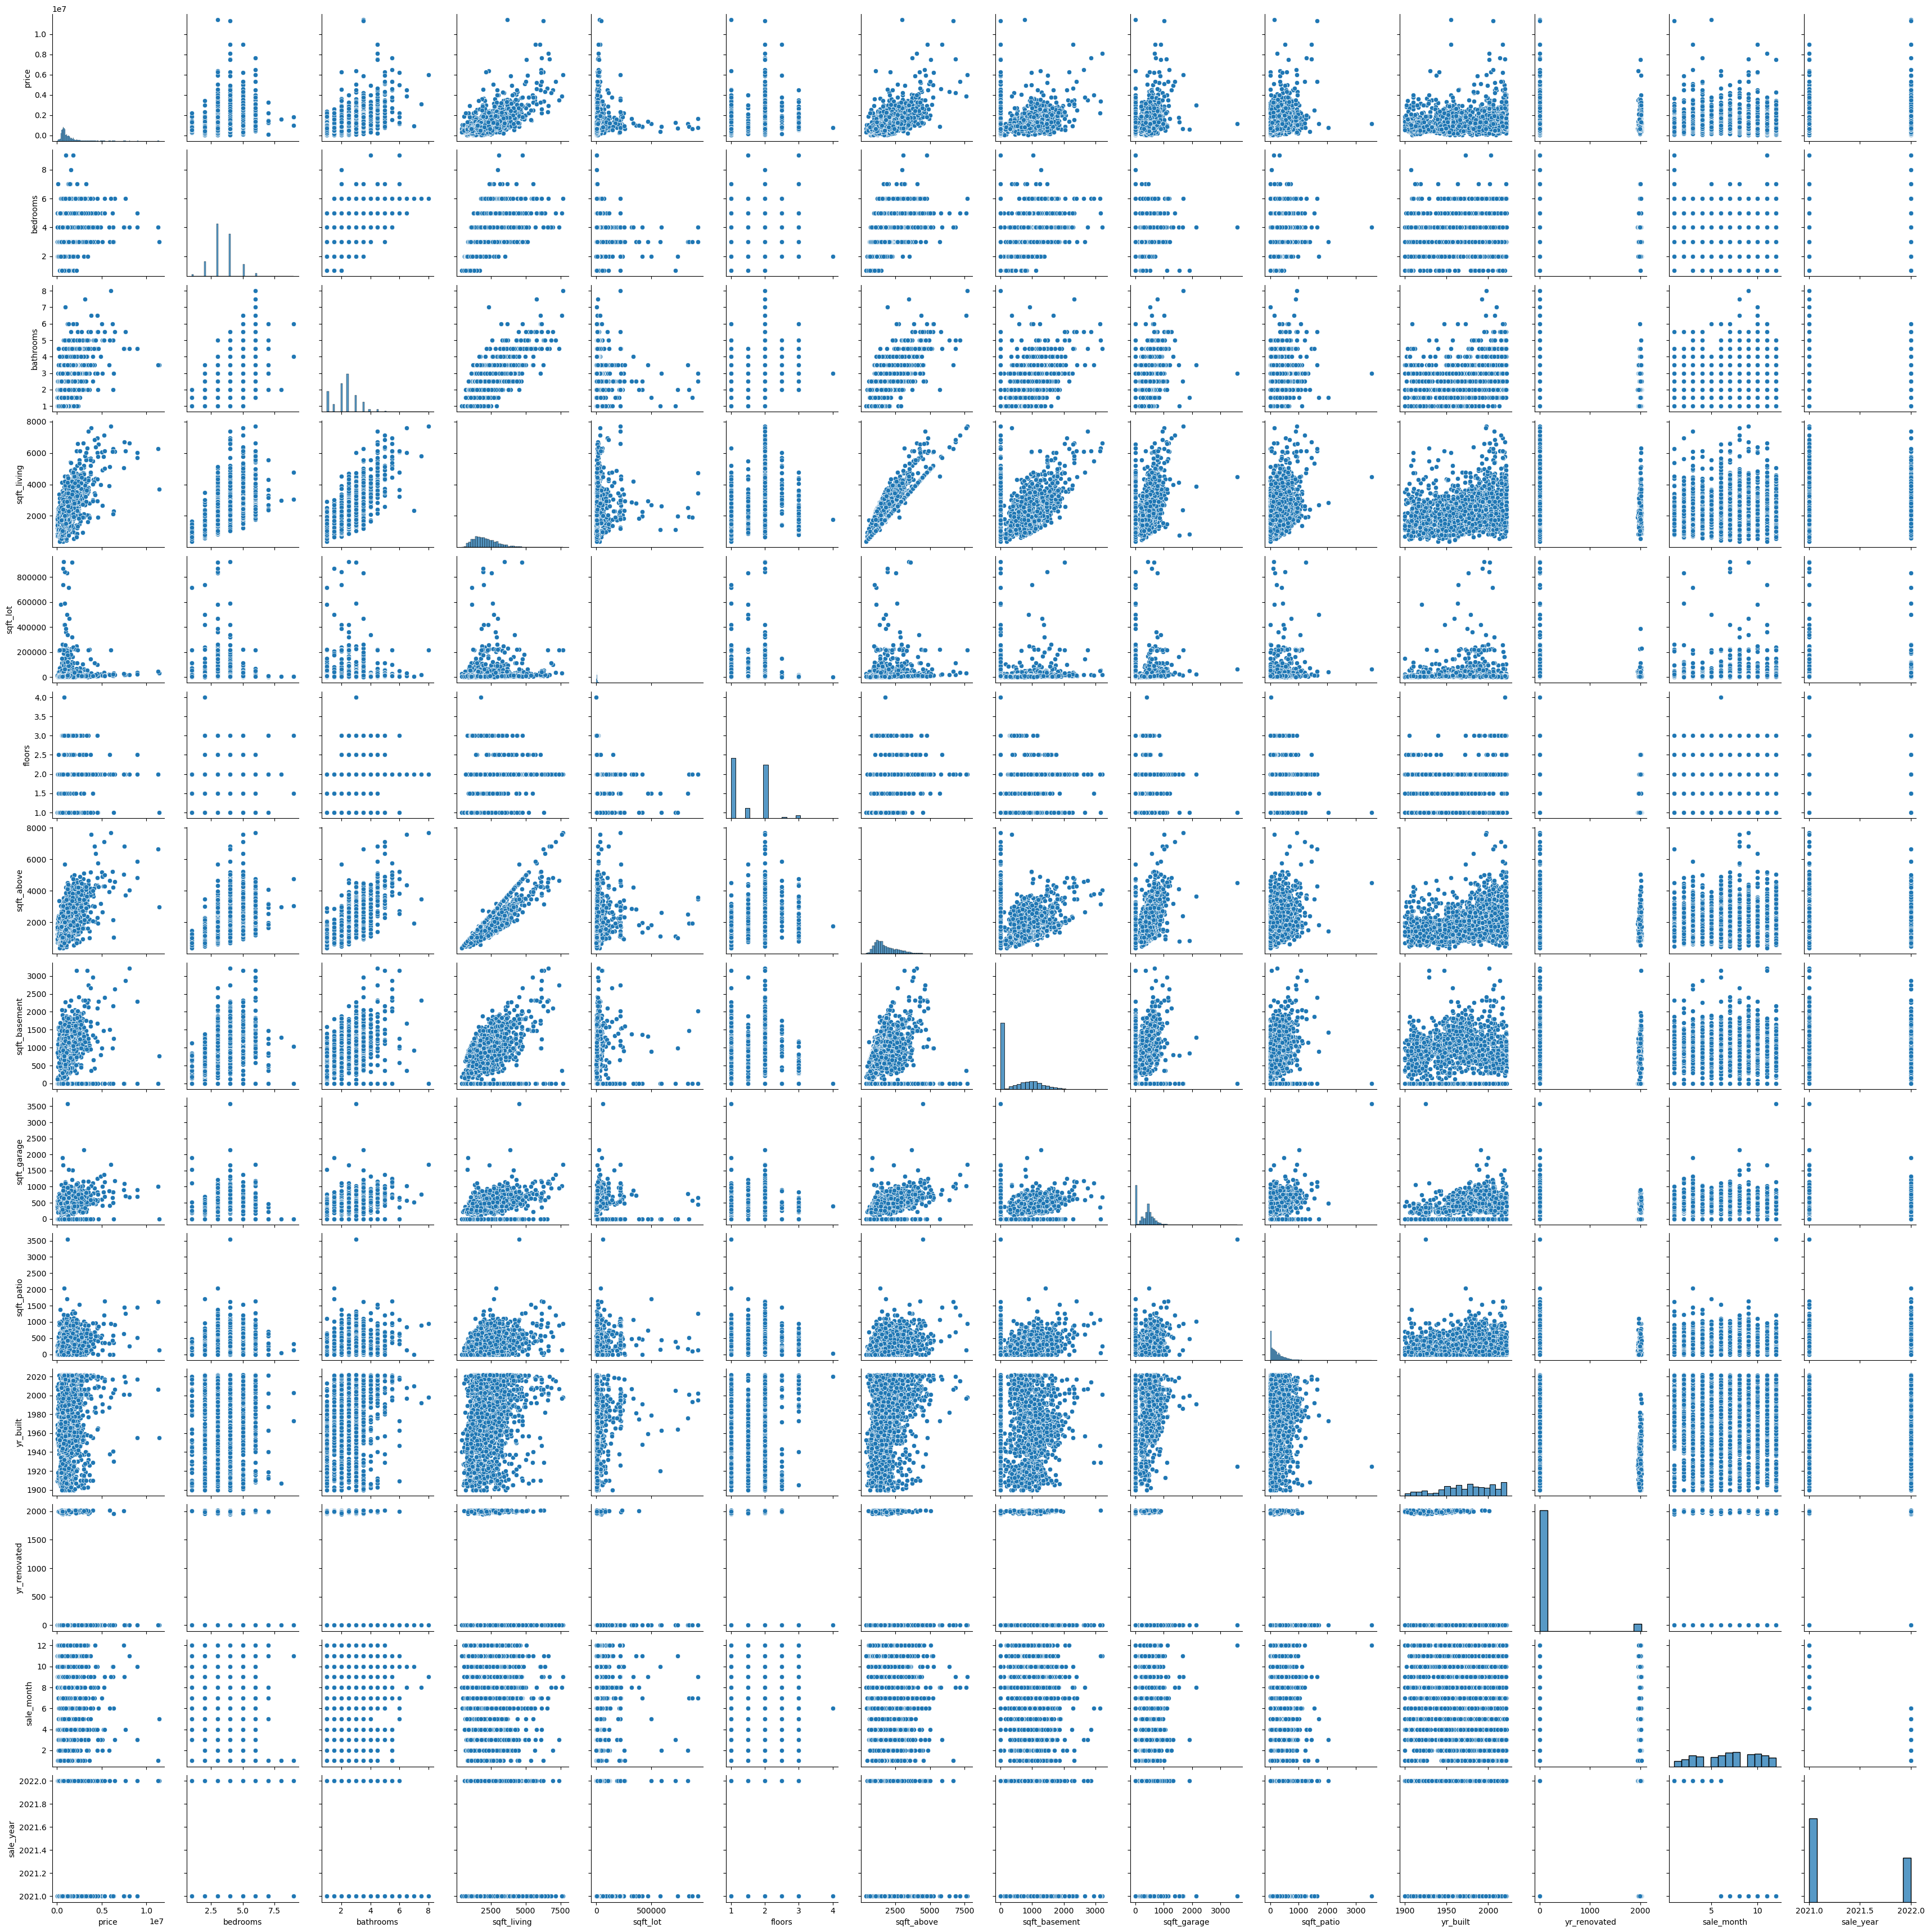

In [11]:
sns.pairplot(df.sample(3000));

Based on our Heatmap and pairplot, we made the following five observations:

1.) Sqft_living is the most correlated feature with price 

2.) Multi-colinearity between determinents of house size (sqft_living, bedrooms, bathrooms, basement, lot_size)

3.) Target (price), sqft_living, sqft_above, sqft_patio not normally distributed. need to log

4.) Potential interactions: sqft_lot-sqft-living, sqft_basement-sqft_garage

5.) Sqft_living and sqft_above very colinear. probably need to drop one 


In [13]:
#Perform pre-processing transformations on non-normal columns in order to make sure that independent variables 
#are normally distributed
df['log_price'] = np.log(df['price'])
df['log_sqft_living'] = np.log(df['sqft_living'])
df['log_sqft_above'] = np.log(df['sqft_above'])
df['log_sqft_lot'] = np.log(df['sqft_lot'])

# Baseline Model: sqft living vs log price

In [14]:
# Baseline model will use the single most correlated feature from the original dataframe: sqft_living

model_cols = [ 
 'log_sqft_living']

X = df[model_cols]
y = df['log_price']

base_model = sm.OLS(y, sm.add_constant(X)).fit()
print(base_model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                 1.600e+04
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:09:38   Log-Likelihood:                -19211.
No. Observations:               28964   AIC:                         3.843e+04
Df Residuals:                   28962   BIC:                         3.844e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.7452      0.047    1

# Model 1: Multi-Linear with Numerics Added

In [15]:
model_cols = [ 
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'sale_month',
 'sale_year']

X = df[model_cols]
y = df['log_price']

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled,
                        columns=X.columns,
                        index=X.index)

#ADDED SCALED TO THE MODEL
model_1 = LinearRegression()
model_1.fit(X_scaled, y)
model_1.score(X_scaled, y)

model_1 = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(model_1.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     1888.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:09:39   Log-Likelihood:                -17208.
No. Observations:               28964   AIC:                         3.444e+04
Df Residuals:                   28951   BIC:                         3.455e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.7394      0.003   5333.560

Looking at the Model 1 summary, we decided to do the following:

1. Remove year_renovated to become ordinal later on


2. Remove the log features because it decrease R squared from 0.439 to 0.418


### Checking Linear Regression Assumptions after our first linear regression

1. Independence: Our errors are independent because the Durbin-Watson number is close to 2


2. Multicolinearity: Our condition number is low, which means that we do not have much multicolinearity


3. Normality: We previously looked at the normality of our independnet variables and transformed them using logs

4. linearity: Making sure that the target versus residuals does not fan out too much

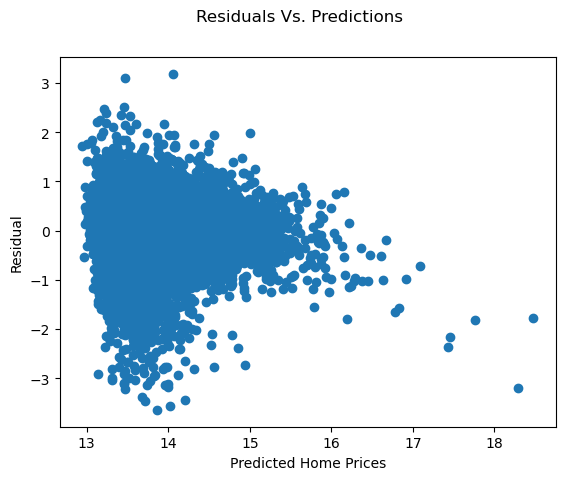

In [16]:
model_pred = model_1.predict()
resids = y - model_pred

fig, ax = plt.subplots()

ax.scatter(model_pred, resids);
ax.set_xlabel('Predicted Home Prices')
ax.set_ylabel('Residual')
plt.suptitle('Residuals Vs. Predictions');

5. Linearity: Below, we also decided to check the linearity for our residuals and our predicted values

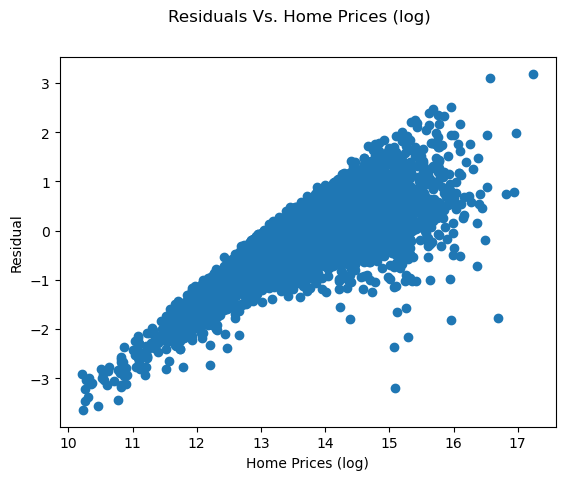

In [17]:

model_pred = model_1.predict()
resids = y - model_pred

fig, ax = plt.subplots()

ax.scatter(y, resids);
ax.set_xlabel('Home Prices (log)')
ax.set_ylabel('Residual')
plt.suptitle('Residuals Vs. Home Prices (log)');

# Model 2: Multi-Linear Regression with numerical data with interactions and dropped Data

### Before running our second model, we wanted to create a few interactions based on the pairplots

In [18]:
#These interactions increase R squared from 0.435 to 0.439. 
#This only seems to happen when I do not use the log features.
df["sqlivingXsqlot"] = df["log_sqft_living"] * df["sqft_lot"]

df["sqbaseXsqgarage"] = df["sqft_basement"] * df["sqft_garage"]


#This interaction increase R squared from 0.439 to 0.442. But Cond Number is also increased
df['living_interaction'] = df['bedrooms'] * df['bathrooms'] * df['sqft_living'] * df['sqft_above'] * df['floors']



In [19]:
#removed: sqft_garage because it did not lower R squared when removed

model_cols = [ 
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'sqft_basement',
 'sqft_patio',
 'yr_built',
 'sale_month',
 'sale_year',
 'sqlivingXsqlot',
 'sqbaseXsqgarage',
 'living_interaction']

X = df[model_cols]
y = df['log_price']

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled,
                              columns=X.columns,
                              index=X.index)

model_2 = LinearRegression()
model_2.fit(X_scaled, y)
model_2.score(X_scaled, y)

model_2 = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(model_2.summary())



                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     1660.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:09:43   Log-Likelihood:                -17045.
No. Observations:               28964   AIC:                         3.412e+04
Df Residuals:                   28949   BIC:                         3.424e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.7394      0

After running our Model 2, here is what we noticed:

1. Our r squared number increased from 0.39 to 0.445

2. Removing sqft_garage because it did not lower the R squared when removed but did lower the condition number

# Model 3: Adding Binary and Ordinal Categorical Data

### Before creating Model 3, we classified variables as binary or ordinal

In [20]:
df['waterfront'].value_counts()
#waterfront is binary, replace with No = 0, Yes = 1

df['greenbelt'].value_counts()
# #greenbelt is binary, replace with No = 0, Yes = 1

df['nuisance'].value_counts()
# #nuisance is binary, replace with No = 0, Yes = 1

df['yr_renovated'].value_counts()
# encoding yr_renovated to 0 = not renovated and 1 = renovated as a binary variable

df['view'].value_counts()
# #view is ordinal. Set {None: 0, Fair:1, Average:2, Good:3, Excellent:4}

df['condition'].value_counts()
# #condition is ordinal. Set {Poor: 0, Fair:1, Average:2, Good:3, Very Good:4}

df['grade'].value_counts()
# #grade is ordinal. Set {2 Substandard: 0, 3 Poor: 1, 4 Low: 2, 5 Fair: 3, 6 Low Average: 4, 7 Average: 5,
# # 8 Good: 6, 9 Better: 7, 10 Very Good: 8, 11 Excellent: 9, 12 Luxury: 10, 13 Mansion: 11}

7 Average        11501
8 Good            8739
9 Better          3559
6 Low Average     2840
10 Very Good      1346
11 Excellent       401
5 Fair             381
12 Luxury          122
4 Low               46
13 Mansion          23
3 Poor               5
2 Substandard        1
Name: grade, dtype: int64

### Now that we have identified these feature variables as binary or ordinal, we can properly encode them

In [21]:
#Ordinally Encoding the view, condition, and grade features
ord_cat_selector = ['view', 'condition', 'grade']
cat_subset = df[ord_cat_selector]
view_list = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
condition_list = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
grade_list = ['2 Substandard', '3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average', '8 Good', '9 Better'
              , '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']

o_enc = OrdinalEncoder(categories = [view_list, condition_list, grade_list])
o_enc.fit(cat_subset)
o_enc.transform(cat_subset)

X_ord = pd.DataFrame(o_enc.transform(cat_subset),
                        columns = cat_subset.columns)

#Adding view, condition, and grade to dataframe
X_ord.rename(columns = {'view':'view_ord', 'condition': 'condition_ord', 'grade':'grade_ord'}, inplace = True)
df_ord = pd.concat([df, X_ord], axis =1)
df_ord.head()

#Binary coding for waterfront, greenbelt, nuiance and renovation features
df_ord['waterfront'] = df_ord['waterfront'].map({'NO': 0, 'YES': 1})
df_ord['greenbelt'] = df_ord['greenbelt'].map({'NO': 0, 'YES': 1})
df_ord['nuisance'] = df_ord['nuisance'].map({'NO': 0, 'YES': 1})
df_ord['yr_renovated'] = df_ord["yr_renovated"].apply(lambda x: 0 if x == 0 else 1)



In [22]:
#removed: yr_renovated didn't seem to impact R squared
#removed: living-interaction because it reduced cond no with impact R squared

model_cols = ['bedrooms', 
             'bathrooms', 
             'sqft_living', 
             'sqft_lot', 
             'floors', 
             'sqft_above', 
             'sqft_basement',
             'sqft_patio', 
             'yr_built', 
             'sale_month', 
             'sale_year', 
             'waterfront', 
             'greenbelt', 
             'nuisance', 
             'view_ord', 
             'condition_ord', 
             'grade_ord', 
             'sqlivingXsqlot',
             'sqbaseXsqgarage']

X = df_ord[model_cols]
y = df_ord['log_price']

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled,
                              columns=X.columns,
                              index=X.index)

model_3 = LinearRegression()
model_3.fit(X_scaled, y)
model_3.score(X_scaled, y)

model_3 = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(model_3.summary())



                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     1647.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:09:45   Log-Likelihood:                -14966.
No. Observations:               28964   AIC:                         2.997e+04
Df Residuals:                   28944   BIC:                         3.014e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.7394      0.002   57

Noticings on Model 3:

1. R squared increased 


2. Durbin-Watson score is still close to 2


3. Condition number is 35.7



# Model 4: Adding Nominal Categorical Data 

In [23]:
#Added: Interaction variables from before and log_sqft_lot
#Removed: Removed City, Bedrooms, and Bathrooms to reduce condo number
#condsider removing: 'sqft_above', 'sqft_basement', 'sqft_garage', and 'sqft_patio' because 
#they do not really impact the R squared in this regression model
#consider removing: heat_source and and sewer_system are not really doing anything

model_cols = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'ZIP',
            'sqlivingXsqlot',
            'sqbaseXsqgarage'
           ]


#Test, Train, Splitting our independnet(y) and dependent(X) variables
X = df_ord[model_cols]
y = df_ord['log_price']
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

#instantiating OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

#transforming train and test OHE columns
train_ohe = ohe.fit_transform(X_train[['ZIP']])
test_ohe = ohe.transform(X_test[['ZIP']])

#turing OHE columns into dataframes
ohe_train = pd.DataFrame(train_ohe, columns = ohe.get_feature_names_out())
ohe_test = pd.DataFrame(test_ohe, columns = ohe.get_feature_names_out())

#Concating OHE data with Xtrain and Xtest
X_train = pd.concat([X_train.drop(columns =['ZIP']).reset_index(), ohe_train],1)
X_test = pd.concat([X_test.drop(columns =['ZIP']).reset_index(), ohe_test],1)

#apply standard scalar on numeric and ordinal values 
cols_to_scale = ['sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'sqlivingXsqlot',
            'sqbaseXsqgarage'
           ]

ss = StandardScaler()

X_train[cols_to_scale] =ss.fit_transform(X_train[cols_to_scale])

X_test[cols_to_scale] =ss.fit_transform(X_test[cols_to_scale])

#drop one ZIP column into y_intercept
X_train.drop(columns = ['ZIP_98050'], inplace = True)
X_test.drop(columns = ['ZIP_98050'], inplace = True)

# # # #fitting and creating linear model
model_4 = LinearRegression()
model_4.fit(X_train, y_train)
print("This is the train R^2 value: {}".format(round(model_4.score(X_train, y_train), 4)))
print("This is the test R^2 value: {}".format(round(model_4.score(X_test, y_test), 4)))


This is the train R^2 value: 0.7304
This is the test R^2 value: 0.727


Noticings on model 4:

1. Model 4's R squared value increased to 0.7304 on the train and 0.727 on the test



2. I addded the interaction variables from before and log_sqft_lot



3. Removed City, Bedrooms, and Bathrooms to reduce condo number


4. Removed heat_source and and sewer_system as they were not very good predictors



# Model 5: Adding Educational Data

### Before we added King county educational data to our model, we performed some data cleaning and EDA

In [24]:
# Create a city/town - school district map

school_district_map = {
    "Seattle" : "Seattle School District",
    "Renton" : "Renton School District",
    "Kent": "Kent School District",
    "Auburn": "Auburn School District",
    "Bellevue": "Bellevue School District",
    "Kirkland": "Lake Washington School District",
    "Federal Way": "Federal Way School District",
    "Redmond": "Lake Washington School District",
    "Sammamish": "Issaquah School District", 
    "Maple Valley": "Tahoma School District",
    "Shoreline": "Shoreline School District",
    "Burien": "Highline School District",
    "Woodinville": "Northshore School District",
    "Issaquah": "Issaquah School District",
    "Covington": "Kent School District",
    "North Bend": "Snoqualmie Valley School District",
    "Enumclaw": "Enumclaw School District",
    "Des Moines": "Highline School District",
    "Mercer Island": "Mercer Island School District",
    "Kenmore": "Northshore School District",
    "Snoqualmie": "Snoqualmie Valley School District",
    "Black Diamond": "Tahoma School District",
    "Bothell": "Northshore School District",
    "SeaTac": "Highline School District",
    "Duvall": "Riverview School District",
    "Lake Forest Park": "Shoreline School District",
    "Vashon": "Vashon Island School District", 
    "Newcastle": "Issaquah School District",
    "Tukwila": "Tukwila School District",
    "Carnation": "Riverview School District",
    "Normandy Park": "Highline School District", 
    "Fall City": "Snoqualmie Valley School District",
    "Pacific": "Auburn School District",
    "Ravensdale": "Tahoma School District",
    "Clyde Hill": "Bellevue School District",
    "Medina": "Bellevue School District",
    "Algona": "Auburn School District",
    "Milton": "Fife School District",
    "Skykomish": "Skykomish School District",
    "Yarrow Point": "Bellevue School District",
    "Beaux Arts": "Bellevue School District",
    "Hunts Point": "Bellevue School District",
    "Baring": "Skykomish School District",
    "Preston": "Issaquah School District",
    "Hobart": "Tahoma School District",
    "Union Hill-Novelty Hill": "Lake Washington School District",
    "Snoqualmie Pass": "Snoqualmie Valley School District",
    "Lakeland North": "Auburn School District",
    "Fairwood": "Kent School District",
    "Cottage Lake": "Northshore School District",
    "Ames Lake": "Snoqualmie Valley School District",
    "White Center": "Highline School District",
    "Dilworth": "Vashon Island School District",
}

school_district_data = {
    "school_district": ["Seattle School District", "Renton School District", "Kent School District", "Auburn School District", "Bellevue School District", "Lake Washington School District", "Federal Way School District", "Issaquah School District", "Tahoma School District", "Shoreline School District", "Highline School District", "Northshore School District", "Snoqualmie Valley School District", "Enumclaw School District", "Mercer Island School District", "Riverview School District", "Vashon Island School District", "Tukwila School District", "Fife School District", "Skykomish School District"],
    
    "math_scores(%)": [51.6, 32.5, 33.7, 30.2, 65.6, 70.2, 21.7, 69.6, 59.0, 55.2, 21.5, 59.6, 64.4, 40.1, 76.9, 54.7, 51.3, 16.7, 30.8, 23.8],
    
    "ela_scores(%)": [62.7, 42.9, 47.9, 43.6, 72.3, 78.5, 35.6, 76.0, 69.2, 66.6, 33.4, 72.0, 75.3, 56.7, 82.0, 69.0, 62.3, 29.6, 46.2, 71.4],
    
    "graduation_rate(%)": [88, 83, 89, 86, 94, 94, 87, 97, 94, 90, 84, 96, 96, 86, 92, 92, 94, 87, 92, 0.0],
    
    "student_expenditure($)": [18397, 16802, 16005, 16463, 17215, 14934, 16332, 15816, 14991, 15900, 17445, 15766, 15168, 15708, 16665, 15508, 16038, 18473, 15264, 58360],
    
    "kindergarten_readiness(%)": [68.3, 56.0, 47.2, 46.4, 60.0, 65.5, 46.0, 74.6, 63.1, 62.5, 55.5, 73.2, 80.6, 61.4, 78.9, 72.8, 75.0, 48.5, 48.3, 0.0],
    
}

#Here we transformed the data into a dataframe
df_school = pd.DataFrame(school_district_data)


In [25]:
#merging school data with data frame
df_ord["school_district"] = df_ord["City"].map(school_district_map)
df_ord_edu = pd.merge(df_ord, df_school, on = "school_district")

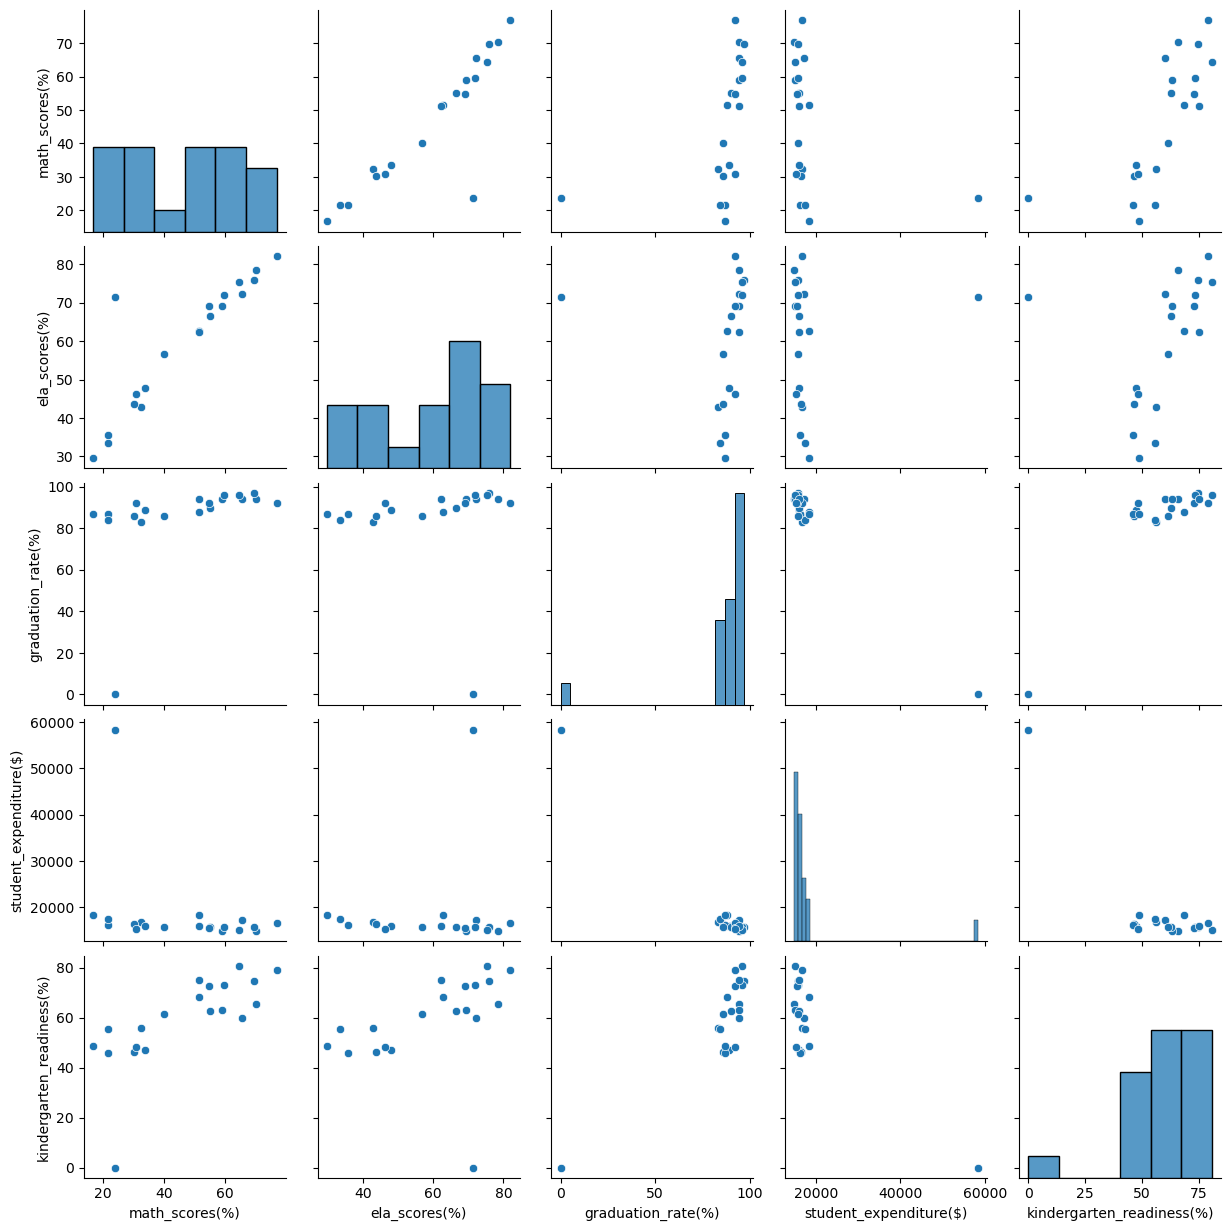

In [26]:
#pairplot of education data (df_school)
sns.pairplot(df_school);

Obersvations on pairplot:

1. Math and ELA scores seem to be multicollinear 


2. There seems to be one smaller outlier. this is the Skykomish School District. I think I will remove these values from the data frame.


In [27]:
#removing Skykomish School District
df_ord_edu["school_district"].value_counts()

Seattle School District              9206
Lake Washington School District      2256
Kent School District                 2084
Renton School District               1943
Issaquah School District             1728
Auburn School District               1635
Bellevue School District             1633
Highline School District             1401
Tahoma School District               1231
Northshore School District           1184
Federal Way School District          1165
Shoreline School District            1012
Snoqualmie Valley School District     866
Enumclaw School District              454
Riverview School District             402
Mercer Island School District         348
Vashon Island School District         190
Tukwila School District               178
Fife School District                   26
Skykomish School District              22
Name: school_district, dtype: int64

In [28]:
#removing Skykomish School District
df_ord_edu = df_ord_edu[df_ord_edu["school_district"] != "Skykomish School District"]
df_ord_edu["school_district"].value_counts()

Seattle School District              9206
Lake Washington School District      2256
Kent School District                 2084
Renton School District               1943
Issaquah School District             1728
Auburn School District               1635
Bellevue School District             1633
Highline School District             1401
Tahoma School District               1231
Northshore School District           1184
Federal Way School District          1165
Shoreline School District            1012
Snoqualmie Valley School District     866
Enumclaw School District              454
Riverview School District             402
Mercer Island School District         348
Vashon Island School District         190
Tukwila School District               178
Fife School District                   26
Name: school_district, dtype: int64

In [29]:
#Potential interaction term for the education data
df_ord_edu["score_interaction"] = df_ord_edu["ela_scores(%)"]*df_ord_edu["math_scores(%)"]*df_ord_edu["student_expenditure($)"]

### Now that we have our data set, we can finally create Model 5

In [43]:
model_cols_1 = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'ZIP',
            'sqlivingXsqlot',
            'sqbaseXsqgarage',
            'ela_scores(%)',
            'graduation_rate(%)',
            'student_expenditure($)',
            'kindergarten_readiness(%)', 
            'score_interaction'
           ]


#Test, Train, Splitting our independnet(y) and dependent(X) variables
X = df_ord_edu[model_cols_1]
y = df_ord_edu['log_price']
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=35)

#instantiating OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

#transforming train and test OHE columns
train_ohe = ohe.fit_transform(X_train[['ZIP']])
test_ohe = ohe.transform(X_test[['ZIP']])

#turing OHE columns into dataframes
ohe_train = pd.DataFrame(train_ohe, columns = ohe.get_feature_names_out())
ohe_test = pd.DataFrame(test_ohe, columns = ohe.get_feature_names_out())

#Concating OHE data with Xtrain and Xtest
X_train_scaled = pd.concat([X_train.drop(columns =['ZIP']).reset_index(), ohe_train],1)
X_test_scaled = pd.concat([X_test.drop(columns =['ZIP']).reset_index(), ohe_test],1)

X_train_scaled.drop(columns = 'index', inplace = True)
X_test_scaled.drop(columns = 'index', inplace = True)

#apply standard scalar on numeric and ordinal values 
cols_to_scale_1 = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'sqlivingXsqlot',
            'sqbaseXsqgarage',
            'ela_scores(%)',
            'graduation_rate(%)',
            'student_expenditure($)',
            'kindergarten_readiness(%)', 
            'score_interaction'
           ]


ss = StandardScaler()

X_train_scaled[cols_to_scale_1] =ss.fit_transform(X_train_scaled[cols_to_scale_1])

X_test_scaled[cols_to_scale_1] =ss.fit_transform(X_test_scaled[cols_to_scale_1])

#drop one ZIP column into y_intercept
X_train_scaled.drop(columns = ['ZIP_98050'], inplace = True)
X_test_scaled.drop(columns = ['ZIP_98050'], inplace = True)


#fitting and creating linear model
model_5 = LinearRegression()
model_5.fit(X_train_scaled, y_train)

print("This is the train R^2 value: {}".format(round(model_5.score(X_train_scaled, y_train), 4)))
print("This is the test R^2 value: {}".format(round(model_5.score(X_test_scaled, y_test), 4)))

y_pred_train = model_5.predict(X_train_scaled)
print("This is the mean abosulte error for model 5 train data: {}".format(mean_absolute_error(np.exp(y_train), np.exp(y_pred_train))))
y_pred_test = model_5.predict(X_test_scaled)
print("This is the mean abosulte error for model 5 test data: {}".format(mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))))

#dict(zip(X_test_scaled.columns, (model_5.coef_)))


This is the train R^2 value: 0.7321
This is the test R^2 value: 0.7265
This is the mean abosulte error for model 5 train data: 200073.8540910152
This is the mean abosulte error for model 5 test data: 192704.36671493025


Noticings on Model 5:

1. On Model 5 we had the hightest R squared and Mean Absolute Error, which means Model 5 is the our best model


2. We dropped the math scores feature because it was highly collinear with the els scores

### Data Analysis on Model 5 for the King County Parks Department

In [31]:
#Creating New DF to explore stakeholder questions on the most undervalued properties in Kings County
stakeholder_df = pd.concat([X_test.reset_index(), y_test.reset_index()],1)


In [32]:
#Cleaning DF
stakeholder_df['price'] = np.exp(stakeholder_df['log_price'])

stakeholder_df = stakeholder_df.loc[stakeholder_df['price'] < 300000]

stakeholder_df.drop(columns = ['index', 'log_price'], inplace = True)

stake_preds = np.exp(model_5.predict(X_test_scaled))[0:184]

eval_df = pd.concat([stakeholder_df.reset_index(), pd.Series((stake_preds))],1)

eval_df.drop(columns = ['index'], inplace = True)

eval_df.rename(columns = {0:'pred_price'}, inplace = True)


In [33]:
#Calculating difference between our model's predicted price and the actual sales price
eval_df['diff'] = eval_df['pred_price']  - eval_df['price']

In [34]:
eval_df = eval_df.sort_values(by = 'pred_price', ascending = True)


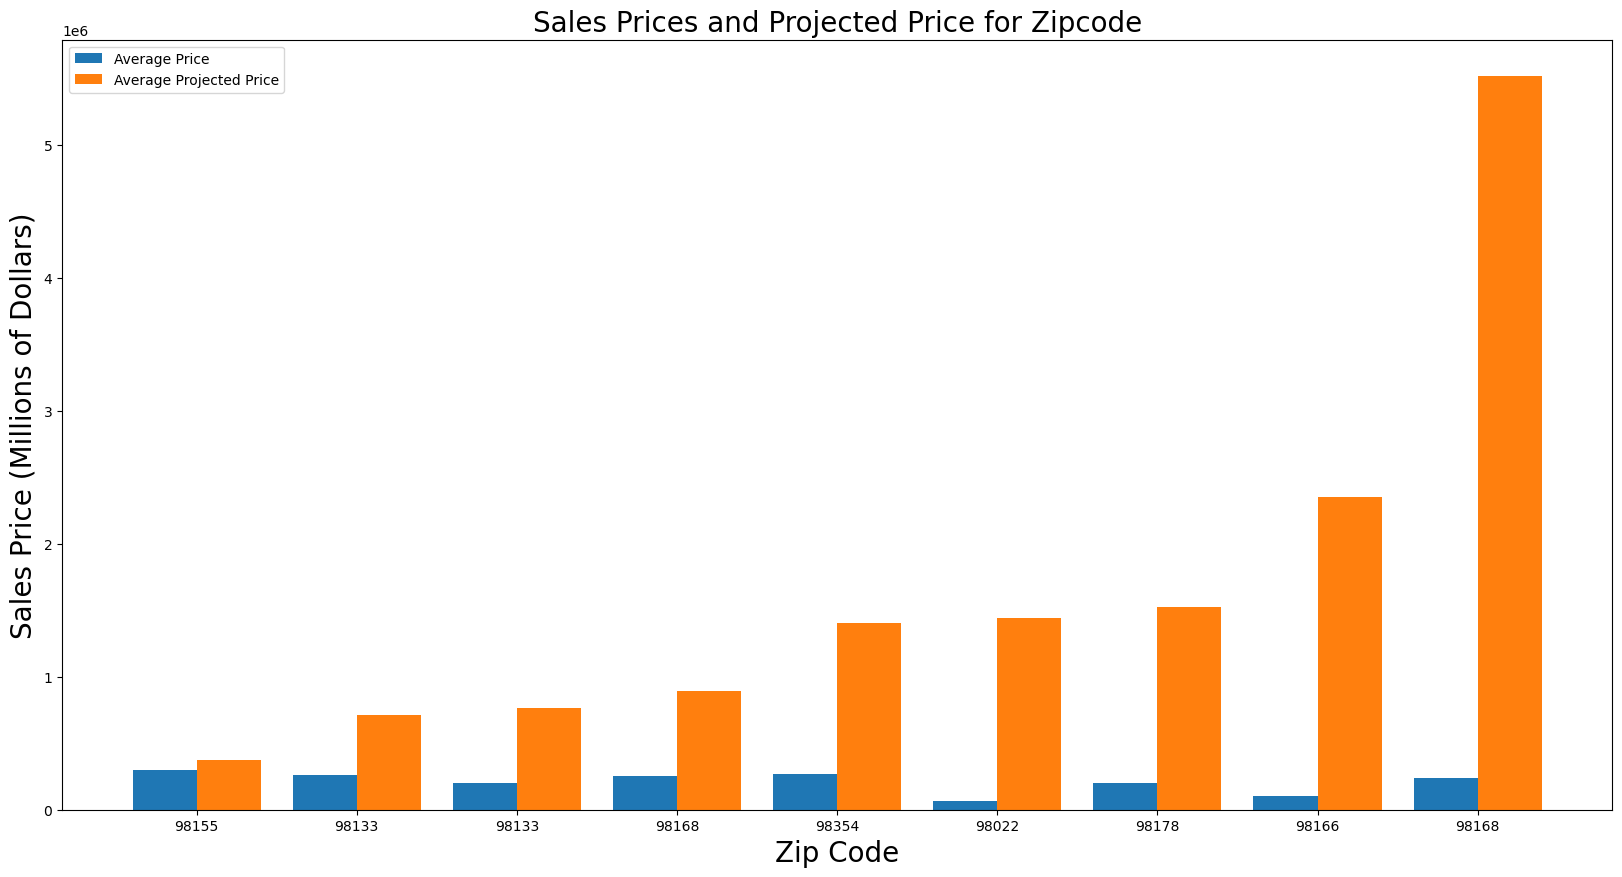

In [35]:
#Here we filtered and created our a bar plot for price and predicted price per zip code

bottom_zipcodes = [98199, 98198, 98023, 98011, 98003, 98032, 98354, 98168, 98047, 98002]

eval_df_zip = eval_df[eval_df["ZIP"].isin(bottom_zipcodes)]

eval_df_2 = eval_df.loc[(eval_df["greenbelt"] == 0) & (eval_df["condition_ord"].isin([0, 1]))]

eval_zip_differential = eval_df_2[["ZIP", "price", "diff"]]

eval_zip_differential["projected_price"] = eval_zip_differential["diff"] + eval_zip_differential["price"]

eval_zip_differential = eval_zip_differential.set_index("ZIP")

eval_zip_differential.groupby("ZIP").mean().sort_values(by = "projected_price", ascending = True)

eval_zip_differential.drop(columns = ["diff"], inplace = True)
eval_zip_differential

price_zip = eval_zip_differential["price"]
projected_price_zip = eval_zip_differential["projected_price"]

fig, ax = plt.subplots(figsize = (20,10))
X_axis = np.arange(len(projected_price_zip))

plt.bar(X_axis - 0.2, price_zip, 0.4, label = 'Average Price')
plt.bar(X_axis + 0.2, projected_price_zip, 0.4, label = 'Average Projected Price')
plt.xticks(X_axis, ["98155", "98133", "98133", "98168", "98354", "98022", "98178", "98166", "98168"])
plt.legend()
plt.ylabel('Sales Price (Millions of Dollars)', fontsize = 20)
plt.xlabel('Zip Code', fontsize = 20)
plt.title("Sales Prices and Projected Price for Zipcode", fontsize = 20);


# Model 6: Add Crime Data 

In [52]:
crime_df = pd.read_csv("data-pozo/crime.csv")
crime_df1 = crime_df.drop(columns = ["case_number", "nibrs_code", "reporting_area", "district", "precinct", "created_at", "updated_at", "hour_of_day", "day_of_week", "ID"])
crime_df1["Year"] = crime_df1["incident_datetime"].apply(lambda x: x[6:10])
crime_df1["city"] = crime_df1["city"].apply(lambda x: str(x).lower().title())
crime_df1.rename(columns = {"city": "City"}, inplace = True)
crime_df1.drop_duplicates(inplace = True)
crime_df1 = crime_df1[(crime_df1["Year"] == "2021") | (crime_df1["Year"] == "2022")]
crime_df1 = crime_df1.drop(columns = ["incident_datetime"])

city_list = ["Seattle", "Renton", "Kent", "Auburn", "Bellevue", "Kirkland", "Federal Way", "Redmond", "Sammamish", "Maple Valley", "Shoreline", "Burien", "Woodinville", "Issaquah", "Covington", "North Bend", "Enumclaw", "Des Moines", "Mercer Island", "Kenmore", "Snoqualmie", "Black Diamond", "Bothell", "Seatac", "Duvall", "Lake Forest Park", "Vashon", "Newcastle", "Tukwila", "Carnation", "Normandy Park", "Fall City", "Pacific", "Ravensdale", "Clyde Hill", "Medina", "Algona", "Milton", "Skykomish", "Yarrow Point", "Beaux Arts", "Hunts Point", "Baring", "Preston", "Hobart", "Union Hill-Novelty Hill", "Snoqualmie Pass", "Lakeland North", "Fairwood", "Cottage Lake", "Ames Lake", "White Center", "Dilworth"]
crime_df1 = crime_df1[crime_df1['City'].isin(city_list)]
crime_df1.dropna(subset = ["nibrs_code_name"])
crime_by_city = crime_df1.groupby(["City"]).count()
crime_by_city = crime_by_city[["nibrs_code_name"]].reset_index()
crime_by_city.rename(columns = {"nibrs_code_name": "crime_number"}, inplace = True)


pop_dict = {"Seattle": 762500, "Renton": 107500, "Kent": 137900, "Auburn": 78690, "Bellevue": 153900, "Kirkland": 93570, "Federal Way": 101800, "Redmond": 75270, "Sammamish": 68150, "Maple Valley": 28920, "Shoreline": 60320, "Burien": 52490, "Woodinville": 13450, "Issaquah": 40950, "Covington": 21200, "North Bend": 7915, "Enumclaw": 12910, "Des Moines": 33160, "Mercer Island": 25780, "Kenmore": 137900, "Snoqualmie": 14490, "Black Diamond": 6145, "Bothell": 29210, "Seatac": 31910, "Duvall": 8320, "Lake Forest Park": 13620, "Vashon": 11055, "Newcastle": 13560, "Tukwila": 22620, "Carnation": 2160, "Normandy Park": 6790, "Fall City": 2032, "Pacific": 7230, "Ravensdale": 390, "Clyde Hill": 3110, "Medina": 2915, "Algona": 3300, "Milton": 13560, "Skykomish": 165, "Yarrow Point": 1125, "Beaux Arts": 315, "Hunts Point": 460, "Baring": 267, "Preston": 523, "Hobart": 6932, "Union Hill-Novelty Hill": 22683, "Snoqualmie Pass": 390, "Lakeland North": 13879, "Fairwood": 10541, "Cottage Lake": 22965, "Ames Lake": 1486, "White Center": 16631, "Dilworth": 0.0}
pop_df = pd.DataFrame(pop_dict, index = [0])
pop_df = pop_df.transpose()
pop_df = pop_df.sort_index()
pop_df = pop_df.reset_index()
pop_df.rename(columns = {"index": "City", 0: "Population"}, inplace = True)

crime_per_capita = pd.merge(crime_by_city, pop_df, on = "City")
crime_per_capita["crime_per_capita"] = crime_per_capita["crime_number"]/ crime_per_capita["Population"]

df_ord_edu_crime = pd.merge(df_ord_edu, crime_per_capita, on = "City")


In [48]:
model_cols_2 = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'ZIP',
            'sqlivingXsqlot',
            'sqbaseXsqgarage',
            'ela_scores(%)',
            'graduation_rate(%)',
            'student_expenditure($)',
            'kindergarten_readiness(%)', 
            'score_interaction',
            'crime_per_capita'
           ]


#Test, Train, Splitting our independnet(y) and dependent(X) variables
X = df_ord_edu_crime[model_cols_2]
y = df_ord_edu_crime['log_price']
X_train, X_test, y_train_2, y_test_2 = train_test_split(
     X, y, test_size=0.33, random_state=35)

#instantiating OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

#transforming train and test OHE columns
train_ohe = ohe.fit_transform(X_train[['ZIP']])
test_ohe = ohe.transform(X_test[['ZIP']])

#turing OHE columns into dataframes
ohe_train = pd.DataFrame(train_ohe, columns = ohe.get_feature_names_out())
ohe_test = pd.DataFrame(test_ohe, columns = ohe.get_feature_names_out())

#Concating OHE data with Xtrain and Xtest
X_train = pd.concat([X_train.drop(columns =['ZIP']).reset_index(), ohe_train],1)
X_test = pd.concat([X_test.drop(columns =['ZIP']).reset_index(), ohe_test],1)

#apply standard scalar on numeric and ordinal values 
cols_to_scale_2 = [
            'sqft_living', 
            'log_sqft_lot', 
            'floors', 
            'sqft_above', 
            'sqft_basement',
            'sqft_garage', 
            'sqft_patio', 
            'yr_built', 
            'yr_renovated', 
            'sale_month', 
            'sale_year', 
            'living_interaction',
            'waterfront', 
            'greenbelt', 
            'nuisance', 
            'view_ord', 
            'condition_ord', 
            'grade_ord', 
            'sqlivingXsqlot',
            'sqbaseXsqgarage',
            'ela_scores(%)',
            'graduation_rate(%)',
            'student_expenditure($)',
            'kindergarten_readiness(%)', 
            'score_interaction',
            'crime_per_capita'
           ]


ss = StandardScaler()

X_train[cols_to_scale_2] =ss.fit_transform(X_train[cols_to_scale_2])

X_test[cols_to_scale_2] =ss.fit_transform(X_test[cols_to_scale_2])

#drop one ZIP column into y_intercept
# X_train.drop(columns = ['ZIP_98050'], inplace = True)
# X_test.drop(columns = ['ZIP_98050'], inplace = True)

#fitting and creating linear model
model_6 = LinearRegression()
model_6.fit(X_train, y_train_2)

#R squared values for model6
print("This is the train R^2 value: {}".format(round(model_6.score(X_train, y_train_2), 4)))
print("This is the test R^2 value: {}".format(round(model_6.score(X_test, y_test_2), 4)))


#Mean Absoulte Error values for model6
y_pred_train = model_6.predict(X_train)
print("This is the mean abosulte error for model 6 train data: {}".format(mean_absolute_error(np.exp(y_train_2), np.exp(y_pred_train))))
y_pred_test = model_6.predict(X_test)
print("This is the mean abosulte error for model 6 test data: {}".format(mean_absolute_error(np.exp(y_test_2), np.exp(y_pred_test))))

This is the train R^2 value: 0.7292
This is the test R^2 value: 0.7052
This is the mean abosulte error for model 6 train data: 189956.19039057696
This is the mean abosulte error for model 6 test data: 198954.98674954072


Noticings on Model 6:

1. The mean absolute error on the test and the R squared on the test is worse than model 5, this means that we will use model 5 instead of model 6

# Final Model: Creating visuals for Model 5's Dataframe

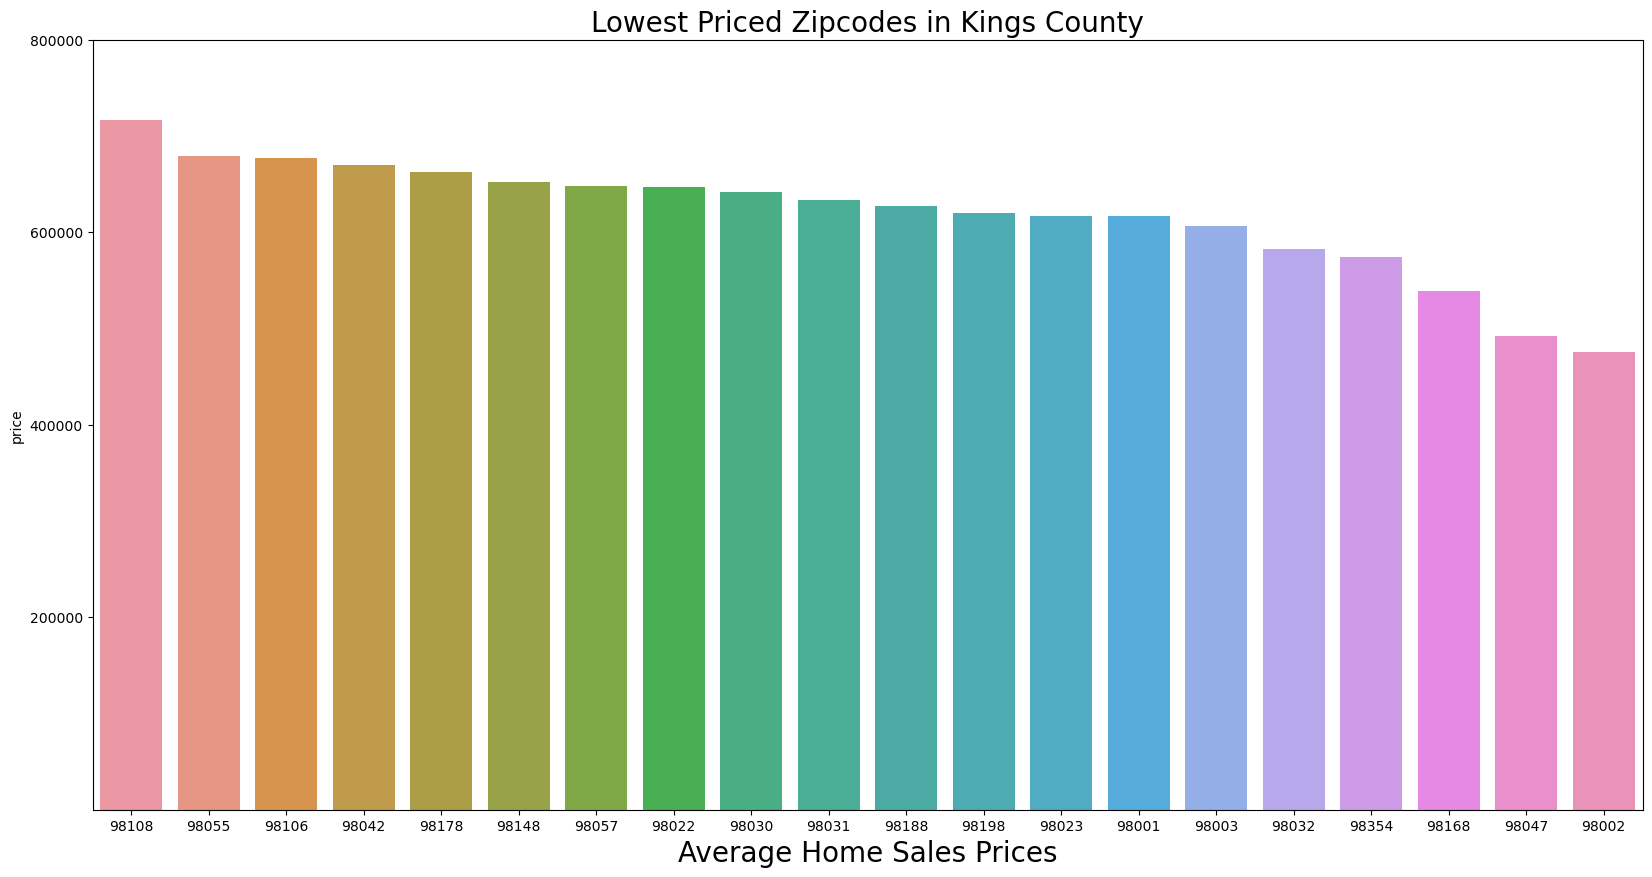

In [51]:
df_price_hist = df_ord_edu[["price", "ZIP"]]
df_price_sort = df_price_hist.groupby("ZIP").mean()
df_price_sort = df_price_sort.reset_index().sort_values("price", ascending = False)

top_10 = df_price_sort.head(10)
last_10 = df_price_sort.tail(20)


fig, ax = plt.subplots(figsize=(20, 10))
# sns.barplot(ax = ax[0], data = top_10, x = "ZIP", y = "price"),
sns.barplot(data = last_10, x = "ZIP", y = "price")
ax.set_yticks([200000, 400000, 600000, 800000])

ax.set_title("Lowest Priced Zipcodes in Kings County", fontsize = 20)
ax.set_xlabel("Average Home Sales Prices", fontsize = 20);

# Final Model: Visualizing Model  5's Test and Train Model

In [46]:
#Calculating residuals for train and test NEED TO SELECT A MODEL!!

# find predicted values
train_preds = model_5.predict(X_train_scaled)
test_preds = model_5.predict(X_test_scaled)

# 1st set of redisduals on train set
resid_train = (train_preds - y_train)

# 2nd set of redisduals on test set
resid_test = (test_preds - y_test)

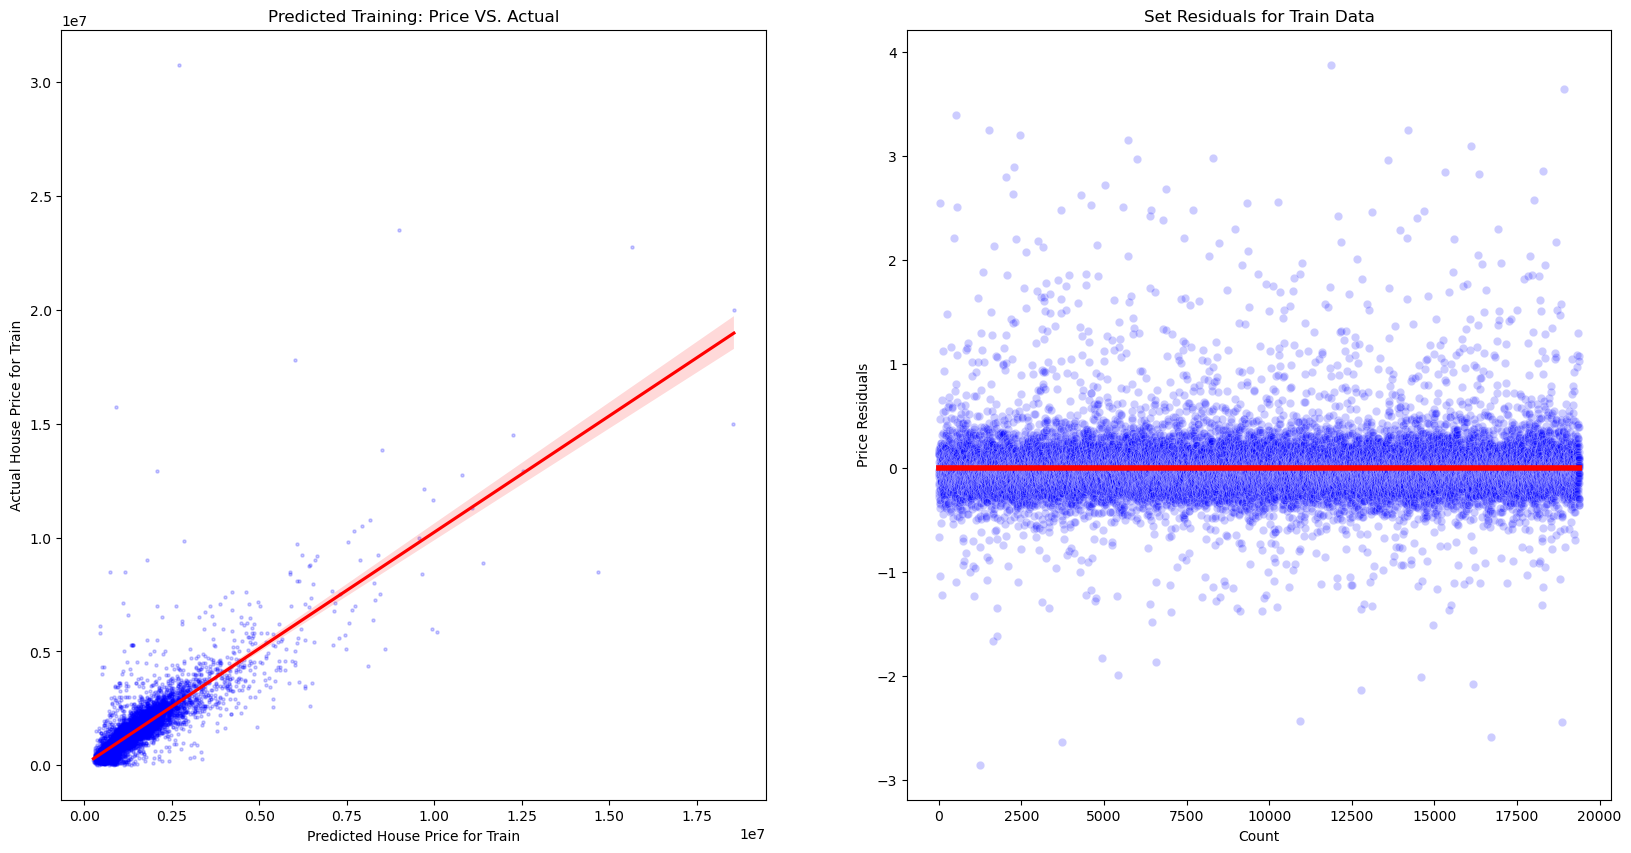

In [49]:
# Plotting our train data and training set residuals

#creating the figure and mutliple axis in our subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

#creating seaborn regplot
sns.regplot(ax = ax[0],  x = np.exp(train_preds), y = np.exp(y_train),
            scatter_kws={'s':5, 'alpha': 0.2, 'color': 'blue'},
            line_kws={"color": "red"})

#adding annotations
ax[0].set_xlabel('Predicted House Price for Train') 
ax[0].set_ylabel('Actual House Price for Train') 
ax[0].set_title('Predicted Training: Price VS. Actual')

# plots residual
sns.scatterplot(ax = ax[1], 
                x=range(y_train.shape[0]),
                y= resid_train, 
                alpha=0.2,
                color = "blue")

# residual zero line
sns.lineplot(ax = ax[1], 
             x=range(y_train.shape[0]), y = 0, 
             color='red', linestyle="solid", linewidth = 4)


#adding annotations
ax[1].set_xlabel('Count') 
ax[1].set_ylabel('Price Residuals') 
ax[1].set_title('Set Residuals for Train Data')

plt.show();

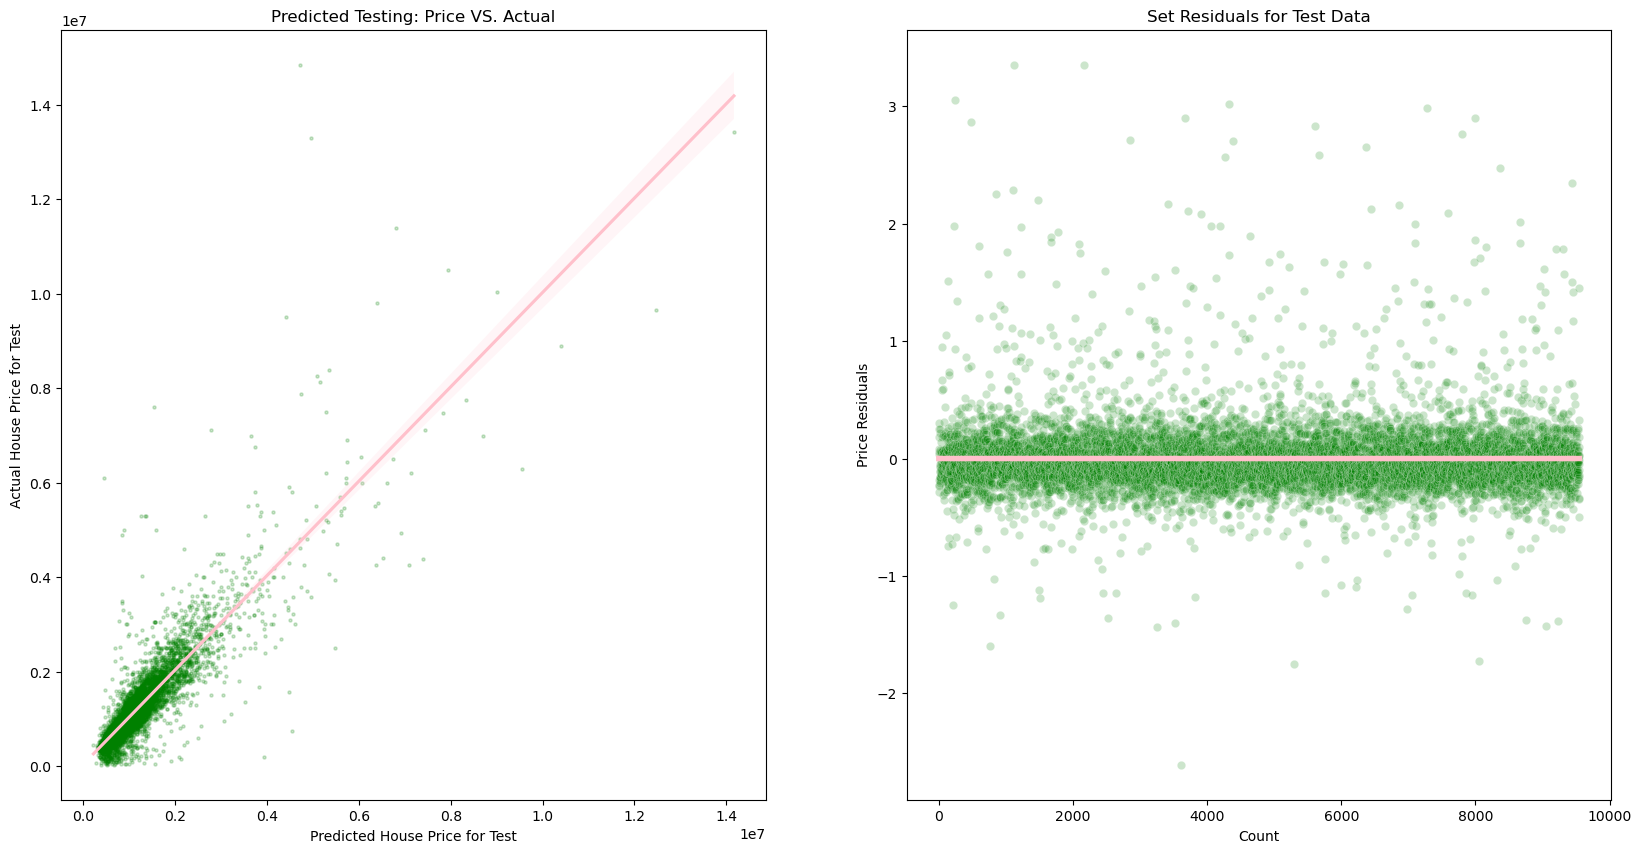

In [50]:
# Plotting our test data and test set residuals

#creating the figure and mutliple axis in our subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

#creating seaborn regplot
sns.regplot(ax = ax[0],  x = np.exp(test_preds), y = np.exp(y_test),
            scatter_kws={'s':5, 'alpha': 0.2, 'color': 'green'},
            line_kws={"color": "pink"})

#adding annotations
ax[0].set_xlabel('Predicted House Price for Test') 
ax[0].set_ylabel('Actual House Price for Test') 
ax[0].set_title('Predicted Testing: Price VS. Actual')

# plots residual
sns.scatterplot(ax = ax[1], 
                x=range(y_test.shape[0]),
                y= resid_test, 
                alpha=0.2,
                color = "green")

# residual zero line
sns.lineplot(ax = ax[1], 
             x=range(y_test.shape[0]), y = 0, 
             color='pink', linestyle="solid", linewidth = 4)


#adding annotations
ax[1].set_xlabel('Count') 
ax[1].set_ylabel('Price Residuals') 
ax[1].set_title('Set Residuals for Test Data')

plt.show();

Looking at the graph of the test model predictions, our model accurately predicts the prices of homes in kings county